### Colab notebook for the activity block analyses in **[Functional dissection of complex and molecular trait variants at single nucleotide resolution](https://www.biorxiv.org/content/10.1101/2024.05.05.592437v1)**

In [11]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from tqdm.auto import tqdm
import gdown

# Read the FASTA file and processed SatMut data

In this section, we load the required input data: (i) a FASTA file containing reference sequences used in the saturation mutagenesis (SatMut) experiment, and (ii) a SatMut data table with pre-processed experimental results, which includes posterior log2 skew values for mutations across different positions and cell types (e.g., K562, HepG2). We parse the FASTA file into a Python dictionary and read the SatMut dataset into a pandas DataFrame for downstream processing.

In [12]:
# --- Download the FASTA file
fasta_url = "https://drive.google.com/file/d/1MMUC50DVLoXWcGQ1iuJbQRpvo5X73dxA/view?usp=drive_link"

fasta_id = fasta_url.split('/d/')[1].split('/')[0]
fasta_file_name = "OL50.uncollapsed.fa"
gdown.download(f"https://drive.google.com/uc?id={fasta_id}", fasta_file_name, quiet=False)

# --- Download the SatMut data file
satmut_url = "https://drive.google.com/file/d/1xjpETTN3okeRXP-IuvZN1ONR0WOSidx_/view?usp=drive_link"

satmut_id = satmut_url.split('/d/')[1].split('/')[0]
satmut_file_name = "satmut_20230921.txt"
gdown.download(f"https://drive.google.com/uc?id={satmut_id}", satmut_file_name, quiet=False)
satmut_df = pd.read_csv(satmut_file_name, sep='\t', low_memory=False)

# Parse FASTA file into dictionary
fasta_dict = {}
with open(fasta_file_name, 'r') as f:
    for line in f:
        line_str = str(line)
        if line_str[0] == '>':
            my_id = line_str.lstrip('>').rstrip('\n')
            fasta_dict[my_id] = ''
        else:
            fasta_dict[my_id] += line_str.rstrip('\n')

Downloading...
From: https://drive.google.com/uc?id=1MMUC50DVLoXWcGQ1iuJbQRpvo5X73dxA
To: /content/OL50.uncollapsed.fa
100%|██████████| 74.7M/74.7M [00:00<00:00, 123MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1xjpETTN3okeRXP-IuvZN1ONR0WOSidx_
From (redirected): https://drive.google.com/uc?id=1xjpETTN3okeRXP-IuvZN1ONR0WOSidx_&confirm=t&uuid=14817ab3-dbaa-4de5-9989-490d90fb365a
To: /content/satmut_20230921.txt
100%|██████████| 219M/219M [00:01<00:00, 133MB/s]


# Convert the satmut data into arrays

Here we iterate over all parent sequences and cell types, compiling mutation effect data into a 4xN effect array, capturing the log2 skew for each base (A, C, G, T) at each position. An average "effect mean" array across mutations, representing aggregate directional signal. These are stored in the dataframe skew_info_df.

In [13]:
alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
cell_types = ['K562', 'HepG2']
parent_ids = sorted(satmut_df['sat_ref'].unique())

# Store results here
skew_info = []

# Process each cell type and parent ID
for cell_type in cell_types:
    for parent_id in tqdm(parent_ids, desc=f'Processing {cell_type}'):
        # Filter data for this cell type and parent ID
        seq_family = satmut_df[(satmut_df['sat_ref'] == parent_id) &
                                 (satmut_df['cell_type'] == cell_type.upper())]
        seq_family = seq_family[seq_family['oligomut'] != 'm0']

        if seq_family.empty:
            continue

        # Get reference sequence and metadata
        ref_sequence = fasta_dict[f'{parent_id}:m0']
        metadata = seq_family[['sat_ref_parent', 'var1', 'var2']].iloc[0]

        # Calculate effect array
        effect_array = np.zeros((4, len(ref_sequence)))
        for _, row in seq_family.iterrows():
            position = row['mut_pos'] - 1  # Convert to 0-based
            token_idx = alphabet_dict[row['mut_base']]
            effect_array[token_idx, position] = row['post_log2Skew']

        # Calculate average effect at each position
        effect_means = -effect_array.sum(axis=0) / 3.0

        # Store results
        skew_info.append([
            parent_id, cell_type, metadata['sat_ref_parent'],
            metadata['var1'], metadata['var2'],
            effect_array, effect_means, ref_sequence
        ])

# Convert results to DataFrame
skew_info_df = pd.DataFrame(
    skew_info,
    columns=['ID', 'cell_type', 'sat_ref_parent', 'var1', 'var2',
             'effect_array', 'effect_means', 'ref_sequence']
)

Processing K562:   0%|          | 0/292 [00:00<?, ?it/s]

Processing HepG2:   0%|          | 0/292 [00:00<?, ?it/s]

# Identify activity blocks

This section detects regions in each sequence where mutations show consistent, directional effects —either activation or repression— using a smoothed signal. These regions are termed activity blocks and may indicate functional TF binding motifs.

`effect_means`: The average mutation effect per position, computed earlier. This array is smoothed and used to detect signal regions.

`gaussian_filter1d(effect_means, sigma=sigma)`: Applies a Gaussian smoothing filter to reduce noise in the signal and emphasize broader trends.

`sigma = 1.15`: Controls the amount of smoothing. Higher values blur more.

The smoothed output is stored in `ysmoothed`.

Two directional thresholds are used: one for up-regulation (+`threshold`) and one for down-regulation (-`threshold`).

`threshold = 0.2`: This sets the baseline for what’s considered significant signal.

`cross_idxs`: Indices where the smoothed signal crosses the threshold. These define the candidate block boundaries.

For each candidate region defined by two successive cross_idxs, the code computes:

`window_mean`: the average effect signal in that region.

`window_len`: the number of bases in the region.

A region is retained as a valid block if its absolute average signal is greater than or equal to `min_mean = 0.15`, and it spans at least `min_len = 5` bases.

Blocks are tagged with a direction (+1 or -1), which is based on whether the signal is positive (activating) or negative (repressing).

Results are stored in `block_calls_dict[cell_type][seq_id]` as a tuple: `block_start_stops`: List of (start, stop) index pairs for each block; `block_directions`: Corresponding directions (+1 or -1) for each block.

In [15]:
# Parameters for block detection
min_mean, min_len, sigma, threshold = 0.15, 5, 1.15, 0.2

# Store results
block_calls_dict = {}

# Process each sequence
for cell_type in tqdm(cell_types, desc='Identifying blocks'):
    input_df = skew_info_df[skew_info_df['cell_type'] == cell_type].reset_index(drop=True)
    block_calls_dict[cell_type] = {}
    for _, row in input_df.iterrows():
        effect_means = row['effect_means']
        seq_id = row['ID']

        # Apply Gaussian smoothing to effect means
        ysmoothed = gaussian_filter1d(effect_means, sigma=sigma)

        block_start_stops = []
        block_directions = []

        # Process both positive and negative blocks
        for direction, compare_threshold in [(1, threshold), (-1, -threshold)]:
            differences = ysmoothed - compare_threshold #if direction == 1 else ysmoothed + compare_threshold

            # Find where the smoothed signal crosses the threshold
            cross_idxs = np.where(np.sign(differences * np.roll(differences, 1)) < 1)[0]

            if len(cross_idxs) > 0:
                if cross_idxs[0] != 0:
                    cross_idxs = np.concatenate([
                        np.zeros(1), cross_idxs, np.array([len(differences)])
                    ]).astype(int)

                # Check each potential block
                for i in range(1, len(cross_idxs)):
                    start, stop = cross_idxs[i-1].item(), cross_idxs[i].item()
                    window_len = stop - start
                    window_mean = effect_means[start:stop].mean()

                    # Check if block meets criteria
                    if direction == 1 and window_mean >= min_mean and window_len >= min_len:
                        block_start_stops.append((start, stop))
                        block_directions.append(direction)
                    elif direction == -1 and window_mean <= -min_mean and window_len >= min_len:
                        block_start_stops.append((start, stop))
                        block_directions.append(direction)

        # Store results
        block_calls_dict[cell_type][seq_id] = (block_start_stops, block_directions)

Identifying blocks:   0%|          | 0/2 [00:00<?, ?it/s]

# Find matches to know TF motifs

### Match utilities

In [16]:
import torch
import scipy.stats as stats

def process_raw_motif(raw_motif):
    pwm = torch.Tensor(raw_motif)
    pwm = pwm * 20 / pwm.abs().sum(dim=0).max().item()
    ppm = torch.softmax(pwm, dim=0)
    icm = ppm * (ppm.log2() * ppm).sum(0).add(2.)
    return ppm, icm

def double_pad(tensor, pad_len):
    padded = torch.zeros((4, 2 * pad_len + tensor.shape[-1] - 2))
    start = pad_len - 1
    padded[:, start:start+tensor.shape[-1]] = tensor
    return padded

def top_n_matches(motif_icm, motif_info, n_top=10):
    pssm_filters = motif_info['pssm_filters']
    all_known_icms = motif_info['all_known_icms']
    all_known_names = motif_info['all_known_names']
    num_motifs = motif_info['num_motifs']
    pad_len = pssm_filters.shape[-1] + 1
    padded_icm = double_pad(motif_icm, pad_len=pad_len)
    scores = torch.nn.functional.conv1d(padded_icm.view(1,4,-1), pssm_filters)[0].detach().numpy()
    max_indices = scores.argmax(axis=-1)
    flat_icm = padded_icm.numpy().flatten()

    aligned_icms = []
    for i in range(pssm_filters.shape[0]):
        pos = max_indices[i]
        icm = all_known_icms[i]
        aligned = np.zeros_like(padded_icm)
        aligned[:, pos:pos+icm.shape[1]] = icm
        aligned_icms.append(aligned.flatten())
    pearsons = np.corrcoef(np.stack(aligned_icms + [flat_icm]))[-1][:-1]
    top_idxs = np.argsort(-pearsons)[:n_top]
    offsets = [max_indices[i].item() - pad_len + 1 for i in top_idxs]
    return top_idxs, pearsons[top_idxs], offsets


def best_insert_match(start, stop, effect_array, effect_means, motif_info,
                      insert_att=0.3, n_top=10):
    window_skews = effect_array[:, start:stop]
    window_mean = effect_means[start:stop].mean()
    direction = np.sign(window_mean)
    raw_motif = direction * window_skews
    _, motif_icm = process_raw_motif(raw_motif)

    top_idxs, top_pearsons, offsets = top_n_matches(motif_icm, motif_info, n_top=n_top)
    insert_pearsons = []
    pvalues = []
    seq_len = effect_means.shape[0]

    for idx, offset in zip(top_idxs, offsets):
        match_icm = motif_info['all_known_icms'][idx]
        match_len = match_icm.shape[1]
        match_start = start + offset
        match_stop = match_start + match_len

        # --- Trim motif if it would extend beyond sequence boundaries
        if match_start < 0:
            match_icm = match_icm[:, -match_start:]
            match_start = 0
        if match_stop > seq_len:
            match_icm = match_icm[:, :seq_len - match_start]
            match_stop = seq_len

        actual_len = match_icm.shape[1]
        if actual_len < 1:
            insert_pearsons.append(0)
            pvalues.append(1)
            continue

        window = direction * effect_array[:, match_start:match_stop]
        _, test_icm = process_raw_motif(window)

        r, p = stats.pearsonr(
            match_icm.flatten(),
            test_icm.numpy().flatten()
        )
        insert_pearsons.append(r.item())
        pvalues.append(p.item())

    # Combine top_n and insert Pearson scores
    deciding_scores = insert_att * np.array(insert_pearsons) + (1 - insert_att) * top_pearsons
    i = deciding_scores.argmax()
    idx = top_idxs[i]
    offset = offsets[i]
    match_icm = all_known_icms[idx]

    best_match_start = int(max(0, start + offset))
    best_match_stop = int(min(seq_len, best_match_start + match_icm.shape[1]))

    return {
        'top_match_name': all_known_names[idx],
        'top_match_icm': match_icm,
        'top_match_start': best_match_start,
        'top_match_stop': best_match_stop,
        'top_block_match_pearson': top_pearsons[i].item(),
        'top_insert_match_pearson': insert_pearsons[i],
        'top_insert_pearson_p_value': pvalues[i],
        'top_n_matches_info': {'motif_names': [all_known_names[i] for i in top_idxs],
                                'pearsons': top_pearsons.tolist(),
                                'start_offsets': offsets,
                                'insert_pearsons': insert_pearsons,
                               'deciding_scores': deciding_scores.tolist(),
                                'pearson_pvalues': pvalues,
                       }
    }

def string_to_numpy(text, dtype=None):
    text = text.strip().replace("]\n", "];")
    return np.asarray(np.matrix(text, dtype=dtype))

### Fetch and prepare known motifs

In [17]:
# --- Fetch the preprocessed TF motifs
motif_url = "https://drive.google.com/file/d/1uhkeJD8BszNMV4V2GXHqN7K3Y76eQZx1/view?usp=drive_link"

file_id = motif_url.split('/d/')[1].split('/')[0]
output_name = "Preprocessed__H12CORE_and_JASPAR2022.txt"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_name, quiet=False)
tf_df = pd.read_csv(output_name, sep=' ', low_memory=False)

# --- Prepare the TF motifs
tf_df = tf_df[tf_df['short_name'].str.isupper()].reset_index(drop=True)
jaspar_rows = tf_df['database'] == 'JASPAR'
tf_df.loc[jaspar_rows, 'name'] = tf_df[jaspar_rows][['short_name', 'name']].agg('_'.join, axis=1)

df_array_columns = ['icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for col in df_array_columns:
    tf_df[col] = tf_df[col].apply(string_to_numpy)

motif_names = tf_df['name'].tolist()
num_motifs = len(motif_names)
PSSMs = torch.Tensor(np.stack(tf_df['padded_pssm'].tolist()))
PSSMs_rc = torch.Tensor(np.stack(tf_df['padded_pssm_rc'].tolist()))
pssm_filters = torch.cat([PSSMs, PSSMs_rc])
all_known_icms = tf_df['icm'].tolist() + tf_df['icm_rc'].tolist()
all_known_names = [name + ' +' for name in motif_names] + [name + ' -' for name in motif_names]

motif_info = {
    'pssm_filters': pssm_filters,
    'all_known_icms': all_known_icms,
    'all_known_names': all_known_names,
    'num_motifs': num_motifs
}

Downloading...
From: https://drive.google.com/uc?id=1uhkeJD8BszNMV4V2GXHqN7K3Y76eQZx1
To: /content/Preprocessed__H12CORE_and_JASPAR2022.txt
100%|██████████| 24.1M/24.1M [00:00<00:00, 102MB/s]


### Scan each sequence's blocks for TF matches

We convert each activity block into an information content matrix (ICM) and find the closest matches to a pre-processed dataset of known transcription factor (TF) motifs from Hocomoco v12 and JASPAR 2022. If after assigning a top match to a block, there are `min_len=5` contiguous positions in the block left unmatched, we ran the matching process again in the remaining sub-block(s). If the length of the list `motif_match_dicts` is greater than one, it means there were recurrent sub-blocks matched. The greater the n_top the longer it takes to run the cell. The top match is determined by a weighted combination (determined by `insert_att` in the function `best_insert_match`) of the pearson correlation of the motif to the just the activity block and the "insertion" Pearson to the satmut window matching the start and stop of the motif match.

In [18]:
n_top = 10

motif_calls_dict = {}
for cell_type in cell_types:
    input_df = skew_info_df[skew_info_df['cell_type'] == cell_type].reset_index(drop=True)
    motif_calls_dict[cell_type] = {}
    for _, row in tqdm(input_df.iterrows(), total=len(input_df), desc=f'Scanning motifs {cell_type}'):
        seq_id = row['ID']
        effect_array = row['effect_array']
        effect_means = row['effect_means']
        cell_type = row['cell_type']
        block_data = block_calls_dict[cell_type][seq_id]

        calls = []
        for (start, stop), direction in zip(*block_data):
            raw_motif = direction * effect_array[:, start:stop]
            _, icm = process_raw_motif(raw_motif)
            match_dict = best_insert_match(start, stop, effect_array, effect_means, motif_info, n_top=n_top)

            block_matches = [match_dict]

            # --- Recursive left
            if match_dict['top_match_start'] - start >= min_len:
                s2 = match_dict['top_match_start']
                m2 = best_insert_match(start, s2, effect_array, effect_means, motif_info, n_top=n_top)
                block_matches.append(m2)
                if s2 - m2['top_match_stop'] >= min_len:
                    s3 = m2['top_match_stop']
                    m3 = best_insert_match(s3, s2, effect_array, effect_means, motif_info, n_top=n_top)
                    block_matches.append(m3)
                elif m2['top_match_start'] - start >= min_len:
                    s3 = m2['top_match_start']
                    m3 = best_insert_match(start, s3, effect_array, effect_means, motif_info, n_top=n_top)
                    block_matches.append(m3)

            # --- Recursive right
            if stop - match_dict['top_match_stop'] >= min_len:
                s2 = match_dict['top_match_stop']
                m2 = best_insert_match(s2, stop, effect_array, effect_means, motif_info, n_top=n_top)
                block_matches.append(m2)
                if m2['top_match_start'] - s2 >= min_len:
                    s3 = m2['top_match_start']
                    m3 = best_insert_match(s2, s3, effect_array, effect_means, motif_info, n_top=n_top)
                    block_matches.append(m3)
                elif stop - m2['top_match_stop'] >= min_len:
                    s3 = m2['top_match_stop']
                    m3 = best_insert_match(s3, stop, effect_array, effect_means, motif_info, n_top=n_top)
                    block_matches.append(m3)

            calls.append({
                'block_start': start,
                'block_stop': stop,
                'block_direction': direction,
                'block_effect_mean': effect_means[start:stop].mean(),
                'block_raw_motif': raw_motif,
                'block_motif_icm': icm.numpy(),
                'motif_match_dicts': block_matches,
            })

        if calls:
            motif_calls_dict[cell_type][seq_id] = calls
        else:
            motif_calls_dict[cell_type][seq_id] = {}

Scanning motifs K562:   0%|          | 0/292 [00:00<?, ?it/s]

Scanning motifs HepG2:   0%|          | 0/292 [00:00<?, ?it/s]

# Generate output files

We compile a list of top-scoring motif matches for each activity block, and a full table of all top-N matches with correlation metrics and p-values. We also annotate the original SatMut dataframe with activity block and direction information.

In [84]:
save_dir = '/content' #None

celltype_matches_dfs = []
celltype_top_n_dfs = []
for cell_type in cell_types:
    blocks_and_matches = motif_calls_dict[cell_type]

    seq_ids = []
    block_ids = []
    block_starts = []
    block_stops = []
    match_names = []
    match_starts = []
    match_stops = []
    match_pearsons = []
    match_pvalues = []
    block_pearsons = []

    top_n_seq_ids = []
    top_n_block_ids = []
    top_n_block_starts = []
    top_n_block_stops = []
    top_n_match_names = []
    top_n_pearsons = []
    top_n_offsets = []
    top_n_window_pearsons = []
    top_n_pvalues = []
    combined_pearsons = []
    for parent_id in tqdm(parent_ids, desc=f'Processing output files {cell_type}'):
        seq_family_filter = (satmut_df['sat_ref'] == parent_id) & (satmut_df['cell_type'] == cell_type.upper())
        seq_block_dicts = blocks_and_matches[parent_id]
        for block_idx, seq_block_dict in enumerate(seq_block_dicts):
            block_id = block_idx + 1
            block_direction = seq_block_dict['block_direction']
            block_start = seq_block_dict['block_start']
            block_stop = seq_block_dict['block_stop']
            block_range = np.arange(block_start, block_stop) + 1

            block_filter = seq_family_filter & satmut_df['mut_pos'].isin(block_range)
            satmut_df.loc[block_filter, 'gaussian_block'] = block_id
            satmut_df.loc[block_filter, 'block_direction'] = int(block_direction)

            block_match_dicts = seq_block_dict['motif_match_dicts']
            for block_match_dict in block_match_dicts:
                seq_ids.append(parent_id)
                block_ids.append(block_id)
                block_starts.append(block_start)
                block_stops.append(block_stop)
                match_names.append(block_match_dict['top_match_name'])
                match_starts.append(block_match_dict['top_match_start'])
                match_stops.append(block_match_dict['top_match_stop'])
                block_pearsons.append(block_match_dict['top_block_match_pearson'])
                match_pearsons.append(block_match_dict['top_insert_match_pearson'])
                match_pvalues.append(block_match_dict['top_insert_pearson_p_value'])

            for block_match_dict in block_match_dicts:
                block_top_n_matches = block_match_dict['top_n_matches_info']
                block_top_n_pearsons = block_top_n_matches['pearsons']
                block_top_n_offsets = block_top_n_matches['start_offsets']
                block_top_n_insert_pearsons = block_top_n_matches['insert_pearsons']
                block_top_n_pearson_p_values = block_top_n_matches['pearson_pvalues']
                block_motif_names = block_top_n_matches['motif_names']
                deciding_scores = block_top_n_matches['deciding_scores']
                for block_motif_name, pearson, offset, window_pearson, pvalue, deciding_score in zip(block_motif_names, block_top_n_pearsons, block_top_n_offsets,
                                                                                     block_top_n_insert_pearsons, block_top_n_pearson_p_values, deciding_scores):
                    top_n_seq_ids.append(parent_id)
                    top_n_block_ids.append(block_id)
                    top_n_block_starts.append(block_start)
                    top_n_block_stops.append(block_stop)
                    top_n_match_names.append(block_motif_name)
                    top_n_offsets.append(offset)
                    top_n_pearsons.append(pearson)
                    top_n_window_pearsons.append(window_pearson)
                    top_n_pvalues.append(pvalue)
                    combined_pearsons.append(deciding_score)

    celltype_matches_df = pd.DataFrame(np.column_stack([seq_ids, block_ids, block_starts, block_stops, match_names, match_starts, match_stops,
                                                        block_pearsons, match_pearsons, match_pvalues]),
                            columns=['sequence_id', 'block_id', 'block_start', 'block_stop',
                                     'match_name', 'match_start', 'match_stop', 'block_pearson', 'insert_pearson', 'insert_pearson_pvalue'])
    celltype_matches_df['cell_type'] = cell_type
    celltype_matches_dfs.append(celltype_matches_df)

    celltype_top_n_df = pd.DataFrame(np.column_stack([top_n_seq_ids, top_n_block_ids, top_n_block_starts, top_n_block_stops,
                                                      top_n_match_names, top_n_offsets, top_n_pearsons, top_n_window_pearsons, top_n_pvalues, combined_pearsons]),
                            columns=['sequence_id', 'block_id', 'block_start', 'block_stop',
                                     'match_name', 'match_offset', 'block_pearson', 'insert_pearson', 'insert_pearson_pvalue', 'combined_pearson'])
    celltype_top_n_df['cell_type'] = cell_type
    celltype_top_n_dfs.append(celltype_top_n_df)

top_matches_df = pd.concat(celltype_matches_dfs, axis=0)
out_cols = list(top_matches_df.columns)
out_col_order = out_cols[:1] + out_cols[-1:] + out_cols[1:-1]
top_matches_df = top_matches_df[out_col_order]

all_top_n_matches_df = pd.concat(celltype_top_n_dfs, axis=0)
name2len_dict = dict(zip(all_known_names, 2*tf_df['length'].to_list()))
all_top_n_matches_df['match_start'] = all_top_n_matches_df[['match_offset', 'block_start']].astype(int).sum(axis=1)
all_top_n_matches_df['match_stop'] = all_top_n_matches_df['match_start'] + \
                                     all_top_n_matches_df['match_name'].apply(lambda x: name2len_dict[x])
out_cols = list(all_top_n_matches_df.columns)
all_top_n_matches_df = all_top_n_matches_df[out_cols[:1] + out_cols[-3:] + out_cols[1:-3]]
all_top_n_matches_df = all_top_n_matches_df.sort_values(by=['sequence_id', 'cell_type', 'block_id', 'combined_pearson'],
                                                        ascending=[True, True, True, False]).reset_index(drop=True)

if save_dir:
    import os
    os.makedirs(save_dir, exist_ok=True)
    top_matches_df.to_csv(save_dir + f'/top_matches_from_top{n_top}.txt', sep='\t', index=None)
    all_top_n_matches_df.to_csv(save_dir + f'/all_top{n_top}_matches.txt', sep='\t', index=None)
    satmut_df.to_csv(save_dir + '/satmut_df_with_gaussian_blocks.txt', sep='\t', index=None)

Processing output files K562:   0%|          | 0/292 [00:00<?, ?it/s]

Processing output files HepG2:   0%|          | 0/292 [00:00<?, ?it/s]

# Generate SatMut plots with match boxes and names

We generate lollipop plots plots showing mutation effects by base and position and the reference sequence logo, along with matched TF motifs with labeled boxes and correlation scores.


### Plot utilities

In [22]:
#--- Plot utilities
!pip install dmslogo

from google.colab import output
output.clear()

import os
import dmslogo
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline


def plot_box(match_dict, block_direction, effect_array, effect_means, box_params, ax):
    start = match_dict['top_match_start']
    stop = match_dict['top_match_stop']
    name = match_dict['top_match_name']
    r = round(match_dict['top_insert_match_pearson'], 2)

    window_effects = effect_means[start:stop]
    window_skews = effect_array[:, start:stop]

    # Set Y box limits
    if block_direction == 1:
        y_min = min(0, window_effects.min()) - 0.5 * box_params['box_pad']
        y_max = max(window_skews.max(), window_effects.max()) + box_params['box_pad']
    else:
        y_min = min(window_skews.min(), window_effects.min()) - box_params['box_pad']
        y_max = max(0, window_effects.max()) + 0.5 * box_params['box_pad']

    ax.vlines([start, stop], y_min, y_max,
              linestyles=box_params['linestyles'], colors=box_params['color'],
              linewidth=box_params['box_linewidth'], alpha=box_params['box_alpha'])
    ax.hlines([y_min, y_max], start, stop,
              linestyles=box_params['linestyles'], colors=box_params['color'],
              linewidth=box_params['box_linewidth'], alpha=box_params['box_alpha'])
    ax.text(start + 0.1, y_max + 0.3, f'{name}\n(r={r})', fontsize=box_params['text_fontsize'], rotation=90)
    return start, stop, ax


def plot_sequence(seq_id, cell_type, skew_info_df, motif_calls_dict, save_dir=None, box_params=None):
    if box_params is None:
        box_params = {'linestyles': 'solid', 'color': 'black', 'box_linewidth': 2,
                      'box_alpha': 0.75, 'text_fontsize': 12, 'box_pad': 0.2}
    seq_df = skew_info_df[(skew_info_df['ID'] == seq_id) & (skew_info_df['cell_type'] == cell_type)]
    motif_calls = motif_calls_dict[cell_type][seq_id]

    row = seq_df[seq_df['ID'] == seq_id].iloc[0]
    ref_seq = row['ref_sequence']
    effect_array = row['effect_array']
    effect_means = row['effect_means']

    colors = ['g', 'b', 'C1', 'r']
    markerfmts = [c + 'o' for c in colors]

    fig, ax = plt.subplots(figsize=(50, 5))
    locs = np.arange(effect_array.shape[1])
    for i in range(4):
        heads = np.array(effect_array[i, :], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = ax.stem(locs + 0.5, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
        plt.setp(stemlines, 'linestyle', 'dashed', 'alpha', 0.2)
        plt.setp(markerline, 'alpha', 0.2)
        plt.setp(baseline, 'alpha', 0.2)
    plt.margins(x=0.0075)

    # Add sequence logo
    temp_data = [list(ref_seq), effect_means]
    temp_df = pd.DataFrame(temp_data).transpose()
    temp_df.columns = ['letter', 'height']

    temp_df['color'] = temp_df.apply(lambda x: colors[alphabet_dict[x['letter']]], axis=1)
    temp_df['site'] = temp_df.index

    min_limit = 1
    y_max = max(min_limit, max(effect_array.max(), effect_means.max()) + 0.1) + 0.5
    y_min = min(-min_limit, min(effect_array.min(), effect_means.min()) - 0.1) - 0.5

    fig, ax = dmslogo.draw_logo(data=temp_df,
                            x_col='site',
                            letter_col='letter',
                            letter_height_col='height',
                            color_col='color',
                            hide_axis=False,
                            fixed_ymax=y_max,
                            fixed_ymin=y_min,
                            ax=ax)

    y_min = min(-1, effect_array.min(), effect_means.min()) - 0.5
    y_max = max(1, effect_array.max(), effect_means.max()) + 0.5
    ax.set_ylim(y_min, y_max)

    # Plot motif boxes
    for block in motif_calls:
        block_direction = block['block_direction']
        for match_dict in block['motif_match_dicts']:
            _, _, ax = plot_box(match_dict, block_direction, effect_array, effect_means, box_params, ax)

    ax.set_xticks(np.arange(4, len(ref_seq) - 1, 5) + 0.5)
    ax.set_xticklabels(np.arange(4, len(ref_seq)-1, 5)+1, fontsize=18)
    ax.set_ylabel('Effect')
    ax.set_title(f'{seq_id}  {cell_type}', fontsize=32, y=1.6)
    fig.set_facecolor('white')

    # Remove top and right axis lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    plt.yticks(fontsize=18)
    plt.xlabel('')
    plt.margins(y=1)

    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        path = os.path.join(save_dir, f'{seq_id}.pdf')
        plt.savefig(path, format='pdf', bbox_inches='tight', dpi=150, transparent=True)
    plt.show()


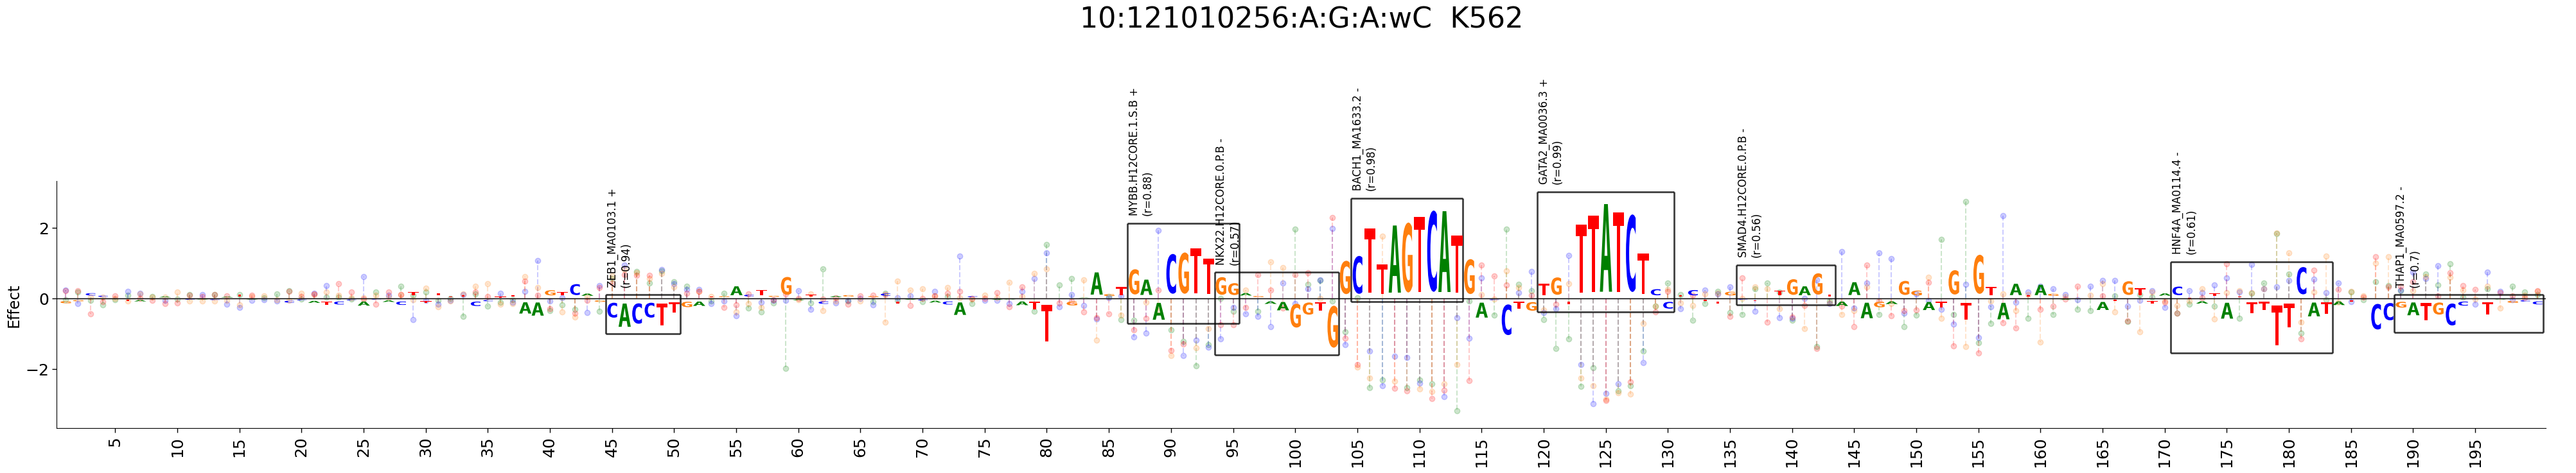

In [23]:
#--- Generate a single plot
seq_id = '10:121010256:A:G:A:wC'
cell_type = 'K562'
save_dir=None

plot_sequence(seq_id, cell_type, skew_info_df, motif_calls_dict, save_dir=save_dir)


#--- Generate all plots
# save_dir=None

# for cell_type in cell_types:
#     for seq_id in motif_calls_dict[cell_type].keys():
#         plot_sequence(seq_id, cell_type, skew_info_df, motif_calls_dict, save_dir=save_dir)